# Día 4: Práctica ARIMA (Parte 1)

Este notebook tiene como objetivo:
1. Revisar la estacionariedad de una serie.
2. Usar ACF y PACF para identificar órdenes p, d, q tentativos.
3. Ajustar un modelo ARIMA básico con `statsmodels`.
4. Evaluar los residuos y la calidad del modelo (AIC, BIC).


In [4]:
# Sección 0: Importaciones y Configuración

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline
sns.set_style('whitegrid')

print("Entorno listo.")


Entorno listo.


## Sección 1: Carga o Creación de Datos

Utilizaremos datos sintéticos para este ejemplo. Si tienes un dataset real, reemplaza la generación de datos por `pd.read_csv(...)`.


In [5]:
# Sección 1: Generamos datos con tendencia + estacionalidad + ruido

np.random.seed(42)

date_range = pd.date_range(start='2025-01-01', end='2025-12-31', freq='D')
n = len(date_range)

trend = np.linspace(50, 150, n)
seasonality = 10 * np.sin(2 * np.pi * np.arange(n) / 30)
noise = np.random.normal(0, 5, n)

values = trend + seasonality + noise

df = pd.DataFrame({'consumo': values}, index=date_range)

df.head()


,consumo
2025-01-01,52.483571
2025-01-02,51.662521
2025-01-03,57.855260
2025-01-04,64.317178
2025-01-05,57.359582


Observamos las primeras filas de la serie `df['consumo']`.

---
## Sección 2: Visualización y Test de Estacionariedad

Antes de aplicar ARIMA, veamos el gráfico y hagamos una prueba de Dickey-Fuller para ver si la serie es estacionaria.


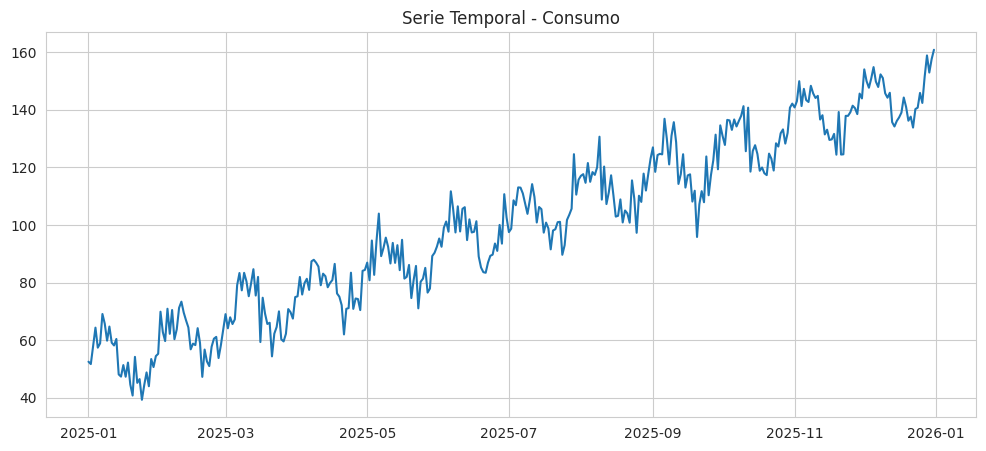

ADF Statistic: -0.2757407584387551
p-value: 0.9288705856408983


In [6]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['consumo'])
plt.title('Serie Temporal - Consumo')
plt.show()

# Prueba de Dickey-Fuller Aumentado
adf_result = adfuller(df['consumo'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


Si la **p-value** es mayor que 0.05, no rechazamos la hipótesis de no estacionariedad.  
Al tener una clara **tendencia**, lo más probable es que **no** sea estacionaria.

---
## Sección 3: Diferenciación (d=1) y nueva prueba


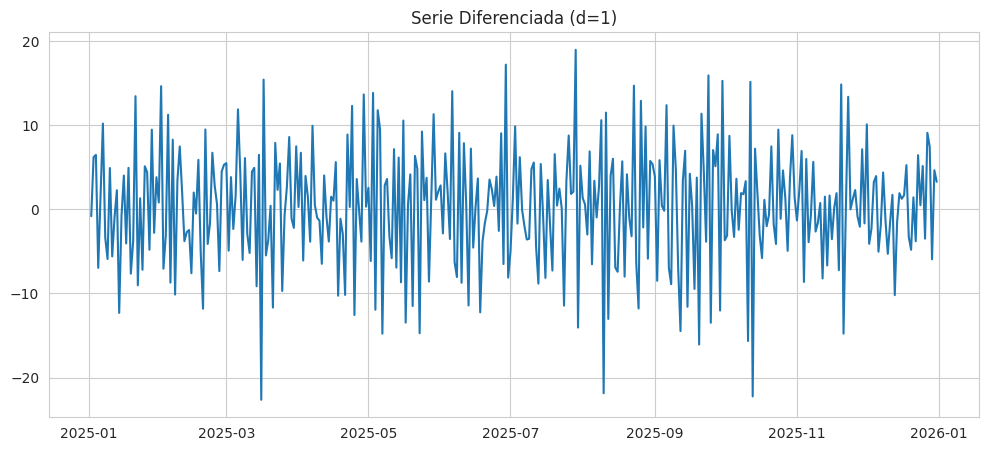

ADF Statistic (Diff1): -10.160551094017961
p-value (Diff1): 7.527967558278953e-18


In [7]:
df['consumo_diff'] = df['consumo'].diff()
df.dropna(inplace=True)

plt.figure(figsize=(12,5))
plt.plot(df.index, df['consumo_diff'])
plt.title('Serie Diferenciada (d=1)')
plt.show()

adf_result_diff = adfuller(df['consumo_diff'])
print("ADF Statistic (Diff1):", adf_result_diff[0])
print("p-value (Diff1):", adf_result_diff[1])


Si ahora la p-value < 0.05, indicaría que la serie diferenciada es estacionaria. Por tanto, **d=1** puede ser apropiado.

---
## Sección 4: ACF y PACF para determinar p y q


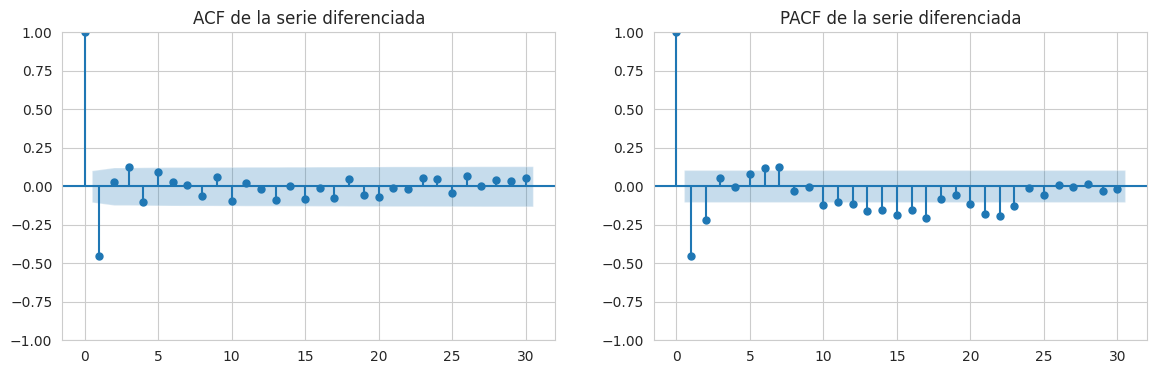

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,4))

# ACF
plot_acf(df['consumo_diff'], lags=30, ax=ax[0])
ax[0].set_title("ACF de la serie diferenciada")

# PACF
plot_pacf(df['consumo_diff'], lags=30, ax=ax[1])
ax[1].set_title("PACF de la serie diferenciada")

plt.show()


Observamos la **columna** en la ACF y PACF:
- **ACF**: Picos tempranos pueden sugerir q.  
- **PACF**: Picos tempranos pueden sugerir p.

Con este ejemplo, tal vez p=1 y q=1 sea razonable (o p=2, q=2), etc.

---
## Sección 5: Ajuste del modelo ARIMA

Probaremos un ARIMA(p=1, d=1, q=1) y revisaremos AIC/BIC.


In [9]:
p, d, q = 1, 1, 1

model = ARIMA(df['consumo'], order=(p, d, q))
results = model.fit()
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                consumo   No. Observations:                  364
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1178.942
Date:                Fri, 31 Jan 2025   AIC                           2363.884
Time:                        17:37:24   BIC                           2375.567
Sample:                    01-02-2025   HQIC                          2368.528
                         - 12-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2259      0.104     -2.163      0.031      -0.431      -0.021
ma.L1         -0.3024      0.106     -2.866      0.004      -0.509      -0.096
sigma2        38.7409      2.763     14.022      0.0

Observa en la salida:  
- **AIC** y **BIC**: cuanto más bajos, mejor.  
- **Parametros**: \(\phi_1\), \(\theta_1\).  

Si deseas comparar distintos (p,d,q), repite el proceso para (2,1,1), (1,1,2), etc., y selecciona según AIC/BIC.

---
## Sección 6: Análisis de Residuales

El modelo ARIMA asume que los residuos son ruido blanco.  
- Graficaremos los residuos y su ACF.


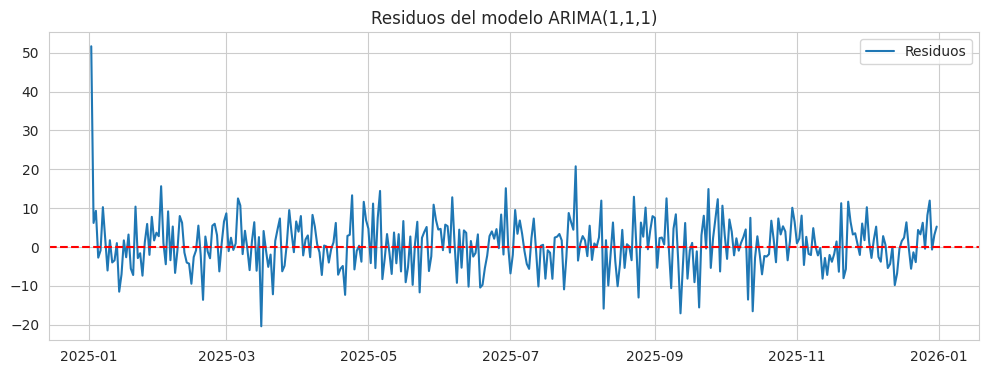

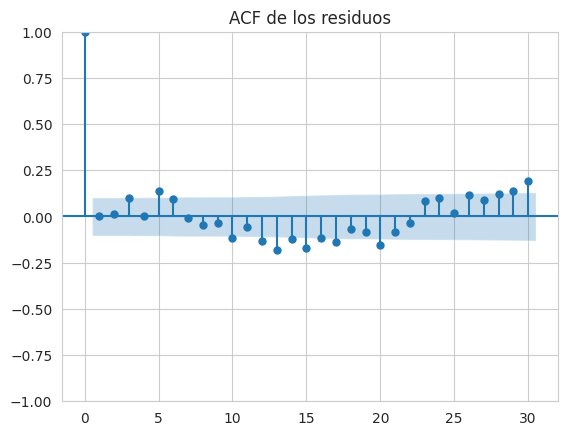

In [10]:
residuals = results.resid

plt.figure(figsize=(12,4))
plt.plot(residuals, label='Residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuos del modelo ARIMA(1,1,1)")
plt.legend()
plt.show()

# ACF de los residuos
plot_acf(residuals, lags=30)
plt.title("ACF de los residuos")
plt.show()


Idealmente, no deberían mostrar autocorrelaciones significativas.

---
## Sección 7: Validación (Breve Ejemplo de Forecast)

Haremos un split entreno-test para un periodo de tiempo y compararemos. 


In [11]:
train_size = int(len(df)*0.8)
train_data = df['consumo'][:train_size]
test_data = df['consumo'][train_size:]

model2 = ARIMA(train_data, order=(p, d, q))
results2 = model2.fit()

start = test_data.index[0]
end = test_data.index[-1]

forecast = results2.predict(start=start, end=end, dynamic=False)


### Visualización


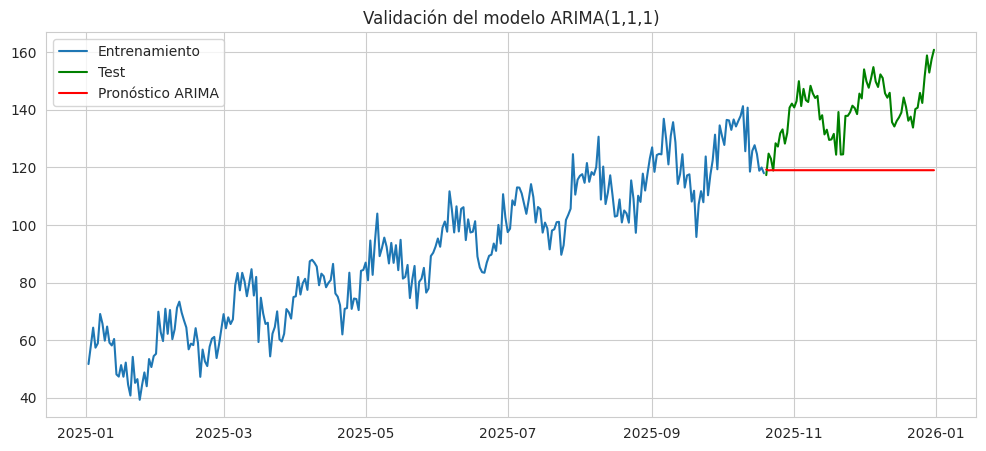

In [12]:
plt.figure(figsize=(12,5))
plt.plot(train_data.index, train_data, label='Entrenamiento')
plt.plot(test_data.index, test_data, label='Test', color='green')
plt.plot(forecast.index, forecast, label='Pronóstico ARIMA', color='red')
plt.legend()
plt.title(f"Validación del modelo ARIMA({p},{d},{q})")
plt.show()


Observamos cómo se ajusta el pronóstico con los datos reales de prueba.

---
## Sección 8: Conclusiones y Tarea

1. **Conclusiones**:
   - ARIMA se basa en la idea de estacionariedad. Requerimos diferenciar la serie si no lo es.
   - ACF y PACF dan una guía inicial para p y q; AIC/BIC refinan la selección.
   - Revisar los residuos es fundamental para asegurarnos de que el modelo cumple los supuestos.

2. **Tarea**:
   - Ajustar varios modelos ARIMA (diferentes p,q) en tu dataset.
   - Comparar AIC/BIC y seleccionar el mejor.
   - Analizar los residuos y elaborar conclusiones.

¡Fin de la práctica ARIMA (Parte 1)!


Recomendaciones finales para la clase
Pausa para la práctica:
Dedica tiempo para que los alumnos prueben diferentes (p,d,q).
Muestra cómo interpretar la tabla con AIC/BIC y la ACF de los residuos.
Refuerzo teórico:
Si sobran unos minutos, menciona que SARIMA (Seasonal ARIMA) se usa para estacionalidad fuerte, y será tema de otra clase (o “Parte 2”).
Ejemplos reales:
Si tienes tiempo, demuestra un dataset real (por ejemplo, ventas diarias) para que los alumnos vean la utilidad en un caso real.
Documentación:
statsmodels: https://www.statsmodels.org/stable/tsa.html
pmdarima (Auto-ARIMA): https://github.com/alkaline-ml/pmdarima
Con este guion de presentación teórica y el notebook de ejemplo, tendrás un material completo para el Día 4 sobre ARIMA. ¡Éxitos en tu clase!